In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import h5py

import sys
sys.path.append('../../')
import analysis_utils as utils
utils.load_plotting_setting()

from scipy.signal import welch
from scipy.optimize import curve_fit

from scipy.fft import rfft, irfft, rfftfreq

In [2]:
import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/gas_collisiions/analysis_notebooks/sphere_20260215/../../analysis_utils.py'>

In [60]:
def read_recon(dataset, voltages):
    file = rf'/Users/yuhan/work/nanospheres/gas_collisiions/data_processed/pulse_calibration/{dataset}_processed.hdf5'

    amps_all, pulse_shapes_all, indices_in_win, zz_pulses_all, drive_area_all, f_res_all = [], [], [], [], [], []
    f = h5py.File(file, 'r')
    for v in voltages:
        amps = f['data_processed'][f'amplitudes_{v}v'][:]
        ps = f['data_processed'][f'pulse_shapes_{v}v'][:]
        indices = f['data_processed'][f'pulse_indices_in_win_{v}v'][:]
        zz = f['data_processed'][f'z_signal_{v}v'][:]
        drive_area = f['data_processed'][f'drive_area_{v}v'][:]
        f_res = f['data_processed'][f'f_res_{v}v'][:]

        amps_all.append(amps)
        pulse_shapes_all.append(ps)
        indices_in_win.append(indices)
        zz_pulses_all.append(zz)
        drive_area_all.append(drive_area)
        f_res_all.append(f_res)

    amps_noise = f['data_processed'][f'amplitudes_noise_2.5v'][:]
    amps_noise_search = f['data_processed'][f'amplitudes_noise_search_2.5v'][:]
    f.close()

    return amps_all, amps_noise, amps_noise_search, pulse_shapes_all, indices_in_win, zz_pulses_all, drive_area_all, f_res_all

def plot_monitoring(dataset, drive_area_all, amps_all, f_res_all, drive_freq, ref_freq, amp2kev):
    cmap = plt.colormaps.get_cmap('viridis')
    colors = cmap(np.linspace(0.2, 0.9, 8))

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for i in range(8):
        norm = drive_area_all[i] * (f_res_all[i]**2 - drive_freq**2)**2 / ((ref_freq**2 - drive_freq**2)**2)
        axes[0].plot(norm, amps_all[i]*amp2kev, '.', color=colors[i], markersize=3.5)

    bins = np.linspace(0.5e-8, 2.5e-8, 150)
    bc = 0.5 * (bins[1:] + bins[:-1])

    _drive = np.concatenate(drive_area_all)
    _freq = np.concatenate(f_res_all)

    drive_freq = 137000
    ref_freq = 48500
    normalized_drive_area = _drive * (_freq**2 - drive_freq**2)**2 / ((ref_freq**2 - drive_freq**2)**2)

    hh, _ = np.histogram(normalized_drive_area, bins=bins)
    axes[1].errorbar(bc, hh, yerr=np.sqrt(hh), fmt='.', color='b', alpha=1)

    axes[0].set_xlim(0, 2e-8)
    axes[0].set_ylim(0, 1600)
    axes[0].set_xlabel(r'Normalized driven $\langle z^2 \rangle$ (a. u.)')
    axes[0].set_ylabel(r'Recon. amp. (keV/c)')

    axes[1].set_ylim(5e-1, 5e2)
    axes[1].set_yscale('log')
    axes[1].set_xlabel(r'Normalized driven $\langle z^2 \rangle$ (a. u.)')
    axes[1].set_ylabel(rf'Counts/({bc[1]-bc[0]:.1e} V$^2$)')

    fig.suptitle(dataset, fontsize=12)
    fig.tight_layout()

    return fig, axes, bc, hh

In [69]:
dataset_0 = '20260219_p6e_4e-8mbar_d137khz_0'
dataset_1 = '20260219_p6e_4e-8mbar_d137khz_1_afterxe'
dataset_2 = '20260219_p6e_4e-8mbar_d137khz_2_afterkr'
dataset_3 = '20260219_p6e_4e-8mbar_d137khz_3_aftersf6'

voltages = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]

amps_all_0, amps_noise_0, amps_noise_search_0, pulse_shapes_all_0, indices_0, zz_pulses_all_0, drive_area_all_0, f_res_all_0 = read_recon(dataset_0, voltages=voltages)
amps_all_1, amps_noise_1, amps_noise_search_1, pulse_shapes_all_1, indices_1, zz_pulses_all_1, drive_area_all_1, f_res_all_1 = read_recon(dataset_1, voltages=voltages)
amps_all_2, amps_noise_2, amps_noise_search_2, pulse_shapes_all_2, indices_2, zz_pulses_all_2, drive_area_all_2, f_res_all_2 = read_recon(dataset_2, voltages=voltages)
amps_all_3, amps_noise_3, amps_noise_search_3, pulse_shapes_all_3, indices_3, zz_pulses_all_3, drive_area_all_3, f_res_all_3 = read_recon(dataset_3, voltages=voltages)

amp2keV 8286.511593357742
Fitted sigma: [47.53169553 65.45596604 54.68706119 65.26626658 59.14143063 63.44503763
 63.17681005 73.68358277] keV/c
Noise level 0.009926231250405924 arb. amplitude
Noise level 82.2538303348386 keV/c
amp2keV 8762.382171284666
Fitted sigma: [43.36885605 61.48853638 62.18697811 67.40030302 81.8067148  95.112149
 85.35247229 71.75638296] keV/c
Noise level 0.007093151010083952 arb. amplitude
Noise level 62.152899948989436 keV/c
amp2keV 8383.777273028216
Fitted sigma: [36.64561875 50.14768703 67.83669247 53.49190085 61.80140454 69.76494352
 57.38410194 65.28075763] keV/c
Noise level 0.006570028178151353 arb. amplitude
Noise level 55.08165292314029 keV/c
amp2keV 8573.217531579674
Fitted sigma: [35.76070793 49.15202562 48.13383769 51.92316203 53.12559603 74.32611979
 80.67285921 84.00772973] keV/c
Noise level 0.006860792321989193 arb. amplitude
Noise level 58.81906501540497 keV/c


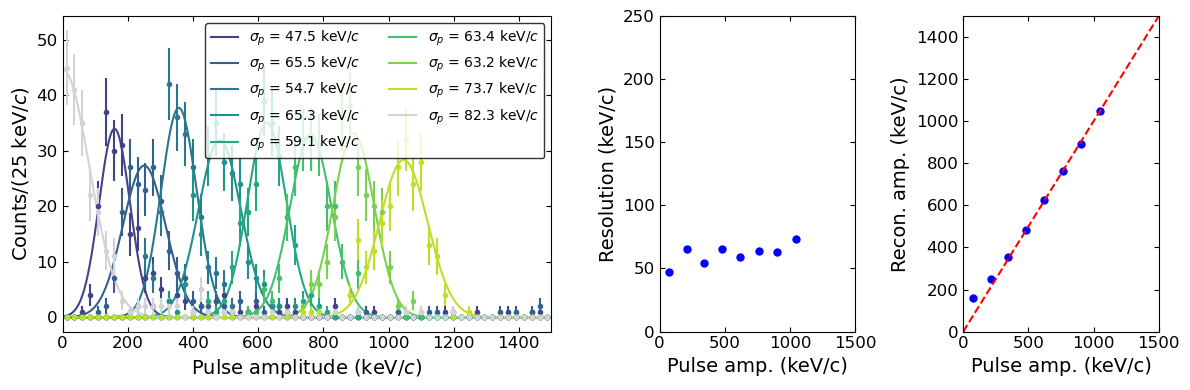

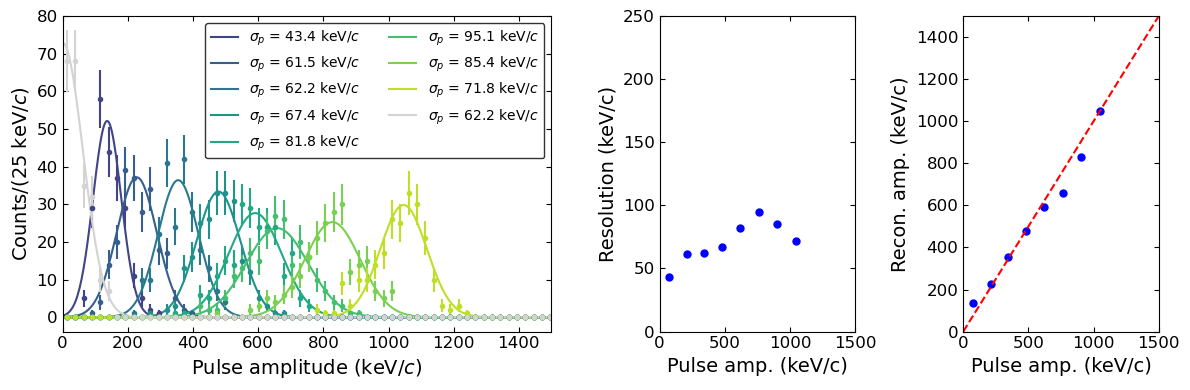

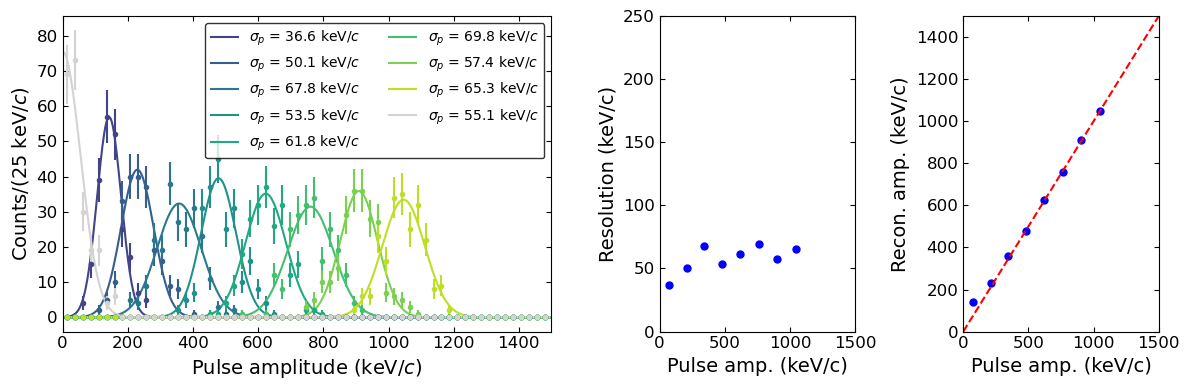

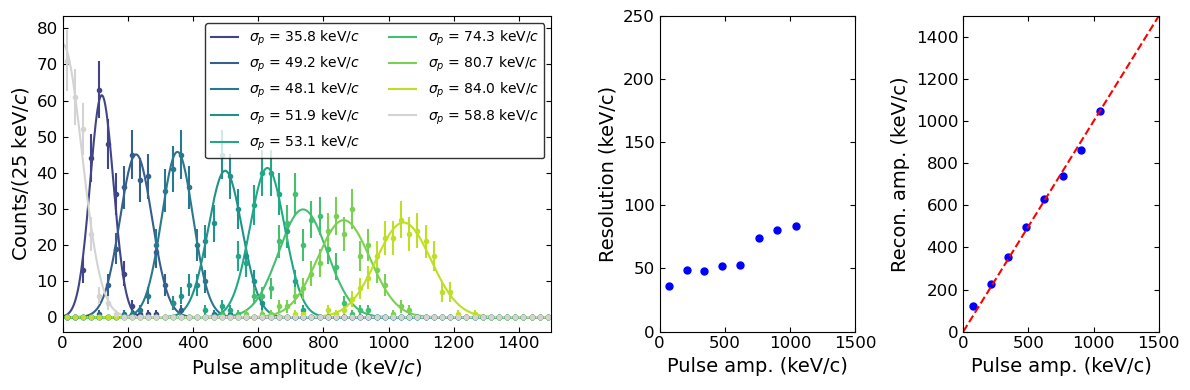

In [71]:
pulse_amp = np.asarray([99, 279, 456, 643, 824, 1018, 1202, 1395]) * 6/8
amps_all = [amps_all_0, amps_all_1, amps_all_2, amps_all_3]
amps_noise_all = [amps_noise_0, amps_noise_1, amps_noise_2, amps_noise_3]

amp2kev_bin = 8563.264990921774
for j in range(len(amps_all)):
    bins = np.arange(0, 3000, 25) / amp2kev_bin
    hhs, bcs, gps = utils.fit_amps_gaus(amps_all[j], bins=bins, noise=False, return_bins=False)
    hhs_noise, bcs_noise, gps_noise = utils.fit_amps_gaus([amps_noise_all[j]], bins=bins, noise=True, return_bins=False)

    amp2kevs = pulse_amp / np.asarray(gps).T[1]
    amp2kev = amp2kevs[-1]

    print('amp2keV', amp2kev)
    print('Fitted sigma:', np.asarray(gps).T[2]*amp2kev, 'keV/c')

    xx = np.linspace(0, np.max(bcs[0]), 1000)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), width_ratios=[2.5, 1, 1])

    cmap = plt.colormaps.get_cmap('viridis')
    colors = cmap(np.linspace(0.2, 0.9, 8))
    for i in range(pulse_amp.size):
        axes[0].errorbar(bcs[i]*amp2kev, hhs[i], yerr=np.sqrt(hhs[i]), fmt='.', color=colors[i])
        axes[0].plot(xx*amp2kev, utils.gauss(xx, *gps[i]), label=fr'$\sigma_p$ = {gps[i][2]*amp2kev:.1f} keV/$c$', color=colors[i])

    axes[0].errorbar(bcs_noise[0]*amp2kev, hhs_noise[0], yerr=np.sqrt(hhs_noise[0]), fmt='.', color='lightgrey')
    axes[0].plot(xx*amp2kev, utils.gauss_zero(xx, *gps_noise[0]), label=fr'$\sigma_p$ = {gps_noise[0][1]*amp2kev:.1f} keV/$c$', color='lightgrey')

    print('Noise level', gps_noise[0][1], 'arb. amplitude')
    print('Noise level', gps_noise[0][1]*amp2kev, 'keV/c')

    axes[0].set_xlim(0, 1500)
    axes[0].legend(edgecolor='k', ncol=2, fontsize=10)
    axes[0].set_xlabel(r'Pulse amplitude (keV/$c$)')
    axes[0].set_ylabel(r'Counts/(25 keV/$c$)')

    # if j == 4:
    #     axes[0].set_title(f'Combined dataset')
    #     axes[0].set_ylim(0, 320)
    # else:
    #     axes[0].set_title(f'{datasets[j]}')
    #     axes[0].set_ylim(0, 80)

    axes[1].plot(pulse_amp, np.asarray(gps).T[2]*amp2kev, 'b.', markersize=10)
    axes[1].set_xlim(0, 1500)
    axes[1].set_ylim(0, 250)
    axes[1].set_xlabel('Pulse amp. (keV/c)')
    axes[1].set_ylabel('Resolution (keV/c)')
    # axes[1].plot(np.linspace(0, 1500, 50), np.full(50, gps_noise[0][1]*amp2kev_all), 'k--')

    axes[2].plot(pulse_amp, np.asarray(gps).T[1]*amp2kev, 'b.', markersize=10)
    axes[2].plot(np.linspace(0, 1500, 50), np.linspace(0, 1500, 50), 'r--')
    axes[2].set_xlim(0, 1500)
    axes[2].set_ylim(0, 1500)
    axes[2].set_xlabel('Pulse amp. (keV/c)')
    axes[2].set_ylabel('Recon. amp. (keV/c)')

    fig.tight_layout()

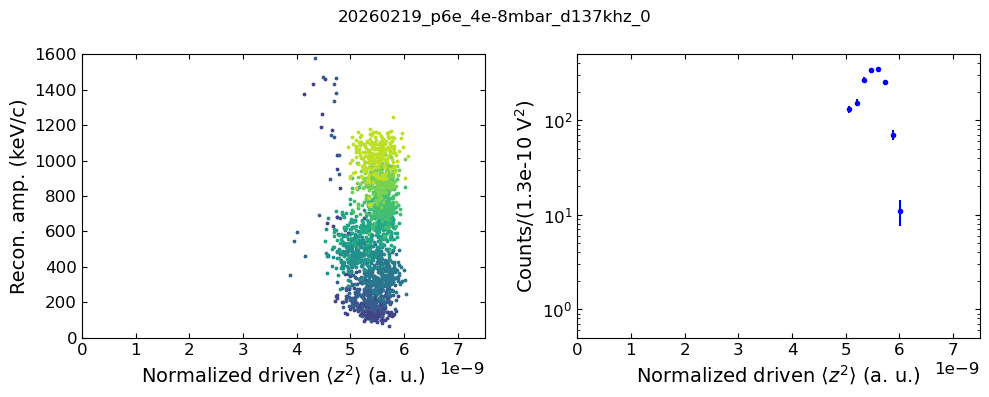

In [64]:
drive_freq = 137000
ref_freq = 48500

fig, axes, bc, hh = plot_monitoring(dataset_0, drive_area_all_0, amps_all_0, f_res_all_0, drive_freq, ref_freq, amp2kev)
for ax in axes:
    ax.set_xlim(0, 0.75e-8)
